In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")


import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("display.max_colwidth", 10)
import re

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC, LinearSVC


import nltk
#nltk.download("stopwords")
#nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.data import load
#nltk.download('tagsets')
tagdict = load('help/tagsets/upenn_tagset.pickle')

import joblib
import pylab as pl
import copy
import csv
import numpy as np

In [2]:
class Sentence:
    habituality = 0 #using a ternary system: -1 = nonhabitual 0 = unclassified, 1 = habitual
    pos1 = 0; pos2 = 0; pos3 = 0; pos4 = 0; pos5 = 0; pos6 = 0; a1 = 0; a2 = 0;
    synPar1 = 0; synPar2 = 0; synPar3 = 0; synPar4 = 0;

    def __init__(self, text):
        self.text = text

### Preprocessing
- Both the output from the Habitual Tagger and the Gold Standard data needed to train the classification model are imported
- Training Data is put into a list of Sentence objects as well as a data frame that will be used later

In [3]:
#CSV file from habitual tagger
tagger_output_path = "C:\\Users\\wiler\\Documents\\College\\Oral History\\features\\habitual be\\habitual rule.csv" 
#sentences with one "be" that have been correctly labeled as habitual or non-habitual to train the tagger
training_data_path = "C:\\Users\\wiler\\Documents\\College\\Oral History\\features\\habitual be\\test gold standard lines+labels.csv" 


In [4]:
#Sentences tagged by the Habitual Tagger are imported into the "preData" dataframe
tagged_sentences = pd.read_csv(tagger_output_path) 
tagged_sentences['Sentence'] = tagged_sentences['Sentence'].str.strip() #takes away white space
print(tagged_sentences)

      Habituality   Sentence  POS1  POS2  POS3  POS4  POS5  POS6  A1  A2  A3  A4  A5  SynPar1  SynPar2  SynPar3  SynPar4  R1
0            -1    Let's ...     1     0     0     0     0     0   0   1   0   0   0        1        0        0        0   0
1            -1    It mig...     1     0     0     0     0     0   0   0   0   0   0        1        0        0        0   0
2            -1    It was...     1     0     0     0     0     0   0   1   0   0   0        1        0        0        0   0
3            -1    It use...     1     0     0     0     0     0   0   0   0   0   0        0        0        0        0   0
4            -1    And I ...     1     0     0     0     0     0   0   0   0   0   0        0        0        0        0   0
...         ...          ...   ...   ...   ...   ...   ...   ...  ..  ..  ..  ..  ..      ...      ...      ...      ...  ..
4526         -1    And th...     1     0     0     0     0     0   0   0   0   0   0        0        1        0        0   0


In [5]:
#Importing Gold Standard Training Data

lines = []
with open(training_data_path, "r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        lines.append(row)
    
# for line in lines:
#     print(line)

#Creates an array of Sentence objects out of gold standard data filtering out sentences with more than one "be"
sen = []
numBe = 0

for i, line in enumerate(lines):
    numBe = 0
    parsed = nlp(line[0])
    for i, word in enumerate(parsed):
        if(word.text.lower() ==  "be"):
            numBe += 1
    if(numBe == 1):
        sen.append(Sentence(line[0]))
        
#puts Sentence objects into a data frame called "data"
data = pd.DataFrame()
for i,sentence in enumerate(sen):
    data = pd.concat([data, pd.DataFrame(tagged_sentences.iloc[i]).T])

print(data)

     Habituality   Sentence POS1 POS2 POS3 POS4 POS5 POS6 A1 A2 A3 A4 A5 SynPar1 SynPar2 SynPar3 SynPar4 R1
0            -1   Let's ...    1    0    0    0    0    0  0  1  0  0  0       1       0       0       0  0
1            -1   It mig...    1    0    0    0    0    0  0  0  0  0  0       1       0       0       0  0
2            -1   It was...    1    0    0    0    0    0  0  1  0  0  0       1       0       0       0  0
3            -1   It use...    1    0    0    0    0    0  0  0  0  0  0       0       0       0       0  0
4            -1   And I ...    1    0    0    0    0    0  0  0  0  0  0       0       0       0       0  0
...         ...         ...  ...  ...  ...  ...  ...  ... .. .. .. .. ..     ...     ...     ...     ... ..
4526         -1   And th...    1    0    0    0    0    0  0  0  0  0  0       0       1       0       0  0
4527         -1   They m...    1    0    0    0    0    0  0  0  0  0  0       1       0       0       0  0
4528         -1   She'd ... 

### N-grams
- This section creates n-grams from the eight word window surrounding "be"
- Each position (4 before and 4 after as well as "be") has a list. For every sentence, the POS of the word in the position is added to it's respective list. If there is no word in the position, a -1 is added to the array instead

In [6]:
#w = word, p = previous (the word before be), pp = preprevious (two words before 'be'), ppp = prepreprevious (three words before 'be')
#a = after (the word after 'be'), pa = postafter ('two words after 'be'), etc
w = []
pppp = []
ppp = []
pp = []
p = []
a = []
pa = []
ppa = []
pppa = []

In [7]:
for Sentence in sen:
    parsed = nlp(Sentence.text)
    for i, word in enumerate(parsed):
        if (word.text.lower() == "be"):
            w.append(word.pos_) #adds POS of "be" to w
            beChildren = list(word.children)
            if(word.head == word):
                beSibling = []
            else:
                beSibling = list(word.head.children)
            beDep = word.dep_
            bePOS = word.pos_
            beIndex = i
            prepreprevious = None
            preprevious = None
            previous = None
            after = None
            postafter = None
            postpostafter = None
            if(i >= 4): #adds POS of 4 words before to pppp
                preprepreprevious = parsed[i-4]
                pppp.append(preprepreprevious.pos_)
            else:
                pppp.append(-1)
            if(i >= 3):
                prepreprevious = parsed[i-3] #adds POS of 3 words before to ppp
                ppp.append(prepreprevious.pos_)
            else:
                ppp.append(-1)
            if(i >= 2):
                preprevious = parsed[i-2] #adds POS of 2 words before to pp
                pp.append(preprevious.pos_)
            else:
                pp.append(-1)
            if(i > 0):
                previous = parsed[i-1]
                p.append(previous.pos_)
            else:
                p.append(-1)
            if(i+1 < len(parsed)):
                after = parsed[i+1]
                a.append(after.pos_)
            else:
                a.append(-1)
            if(i+2 < len(parsed)):
                postafter = parsed[i+2]
                pa.append(postafter.pos_)
            else:
                pa.append(-1)
            if(i+3 < len(parsed)):
                postpostafter = parsed[i+3]
                ppa.append(postpostafter.pos_)
            else:
                ppa.append(-1)
            if(i+4 < len(parsed)):
                postpostpostafter = parsed[i+4]
                pppa.append(postpostpostafter.pos_)
            else:
                pppa.append(-1)

In [8]:
# #print(w)
# print(pppp)
# print(ppp)
# print(pp)
# print(p)
# print(a)
# print(pa)
# print(ppa)
# print(pppa)

In [9]:
#Generating N-grams
corpus = [] 
wlemmatizer = WordNetLemmatizer()
length = len(data['Sentence']) #finding total number of rows
be_window = []
for i in data['Sentence']: 
    start = 0
    end = 0
    parsed = nlp(i)
    for j, word in enumerate(parsed):
        if word.text.lower() == "be":
            if(j >= 4):
                start = j-4
            else:
                start = 0
            if(len(i) > j+4):
                end = j+4
            else:
                end = len(i)
    be_window.append(parsed.text[start:end])
    
for i in range(length):
	rev = re.sub('[^a-zA-Z]',' ',str(be_window[i])) #removes non-alpha characcters
	rev = rev.lower() #text to lowercase
	rev = rev.split()     #splits + lemmatizes each word
	rev = [wlemmatizer.lemmatize(word) for word in rev if word not in stopwords.words('english')]
	rev = ' '.join(rev) #from list to string
	corpus.append(rev) #appending to the list
    
cv = CountVectorizer(ngram_range=(1, 2), max_features=int(length/10))
x = cv.fit_transform(corpus).toarray() #converting to array
y = data['Habituality'] #dependent variable
y = y.astype('int')


              precision    recall  f1-score   support

 nonhabitual       0.80      0.98      0.88      3615
    habitual       0.40      0.05      0.09       916

    accuracy                           0.79      4531
   macro avg       0.60      0.52      0.49      4531
weighted avg       0.72      0.79      0.72      4531



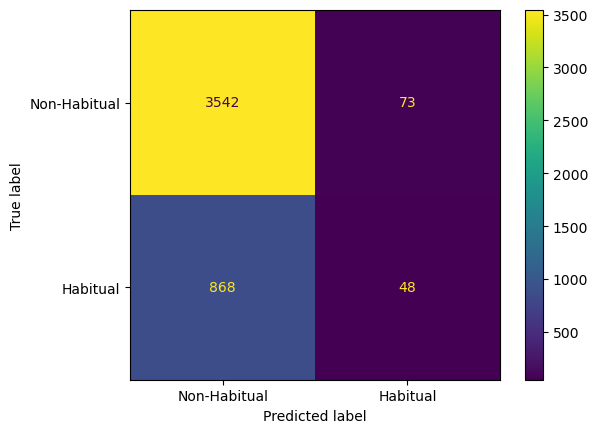

In [10]:
## Training the n-gram model

model = MultinomialNB() # using naive bayes classification algorithm
predict_fit = model.fit(x,y)# fitting the model

kfold = StratifiedKFold(n_splits=10)
predictions = cross_val_predict(model, x, y, cv=kfold)
target_names = ['nonhabitual', 'habitual']

cm = confusion_matrix(y, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Non-Habitual','Habitual'])
cmd.plot()

target_names = ['nonhabitual', 'habitual']
print(classification_report(y, predictions, target_names=target_names))

In [11]:
#Exports model for future use
cvs = cv.transform(corpus)
joblib.dump(cv, "cv.joblib")
joblib.dump(predict_fit, "n_gram.joblib")

['n_gram.joblib']

### Simple Part of Speech
- Adds POS of n-grams to classification model

In [12]:
#Creates a data frame of POS tags from spaCy, then assigns each POS a number
pos_list = pd.DataFrame({'pos': dir(spacy.parts_of_speech)})
num = []
for i in range((len(pos_list))):
    num.append(i)
pos_list.insert(1, 'num', num)
print(pos_list)

          pos  num
0         ADJ    0
1         ADP    1
2         ADV    2
3         AUX    3
4       CCONJ    4
5        CONJ    5
6         DET    6
7         EOL    7
8         IDS    8
9        INTJ    9
10      NAMES   10
11       NOUN   11
12     NO_TAG   12
13        NUM   13
14       PART   14
15       PRON   15
16      PROPN   16
17      PUNCT   17
18      SCONJ   18
19      SPACE   19
20        SYM   20
21       VERB   21
22          X   22
23  __buil...   23
24    __doc__   24
25   __file__   25
26  __load...   26
27   __name__   27
28  __pack...   28
29  __pyx_...   29
30   __spec__   30
31   __test__   31
32  univ_p...   32


In [13]:
#Replaces the text in the POS arrays with numbers
# Replaces the text in the parts of speech arrays with numbers
for i in range(len(w)):
    for j in range(len(pos_list)):
        if (w[i] == pos_list.iloc[j, 0]):
            w[i] = pos_list.iloc[j, 1]
        if (pppp[i] == pos_list.iloc[j, 0]):
            pppp[i] = pos_list.iloc[j, 1]
        if (ppp[i] == pos_list.iloc[j, 0]):
            ppp[i] = pos_list.iloc[j, 1]
        if (pp[i] == pos_list.iloc[j, 0]):
            pp[i] = pos_list.iloc[j, 1]
        if (p[i] == pos_list.iloc[j, 0]):
            p[i] = pos_list.iloc[j, 1]
        if (a[i] == pos_list.iloc[j, 0]):
            a[i] = pos_list.iloc[j, 1]
        if (pa[i] == pos_list.iloc[j, 0]):
            pa[i] = pos_list.iloc[j, 1]
        if (ppa[i] == pos_list.iloc[j, 0]):
            ppa[i] = pos_list.iloc[j, 1]
        if (pppa[i] == pos_list.iloc[j, 0]):
            pppa[i] = pos_list.iloc[j, 1]

In [14]:
#print(w)
# print(pppp)
# print(ppp)
# print(pp)
# print(p)
# print(a)
# print(pa)
# print(ppa)
# print(pppa)

In [15]:
# Adds the part of speech and n-gram arrays into the data array
data.insert(len(data.columns), "n-gram", predictions)
data.insert(len(data.columns), "word", w)
data.insert(len(data.columns), "preprepreprevious", pppp)
data.insert(len(data.columns), "prepreprevious", ppp)
data.insert(len(data.columns), "preprevious", pp)
data.insert(len(data.columns), "previous", p)
data.insert(len(data.columns), "after", a)
data.insert(len(data.columns), "postafter", pa)
data.insert(len(data.columns), "postpostafter", ppa)
data.insert(len(data.columns), "postpostpostafter", pppa)
print(data)

     Habituality   Sentence POS1 POS2 POS3 POS4 POS5 POS6 A1 A2 A3 A4 A5 SynPar1 SynPar2 SynPar3 SynPar4 R1  n-gram  word  preprepreprevious  prepreprevious  preprevious  previous  after  postafter  postpostafter  postpostpostafter
0            -1   Let's ...    1    0    0    0    0    0  0  1  0  0  0       1       0       0       0  0      -1     3         16                  4              15           3     17          6         11              1        
1            -1   It mig...    1    0    0    0    0    0  0  0  0  0  0       1       0       0       0  0      -1     3         -1                 -1              15           3     13         13         17             13        
2            -1   It was...    1    0    0    0    0    0  0  1  0  0  0       1       0       0       0  0      -1     3         15                 21              15           3     17         -1         -1             -1        
3            -1   It use...    1    0    0    0    0    0  0  0  0  0  0

### Classification Models

In [16]:
# Creates array of all the predictive variables
X = data.drop(columns=['Habituality', 'Sentence'], axis=1)

#Creates array of the response variable
y = data['Habituality']

In [17]:
# Ensemble voting classifier using LogReg, MLP, and SVC into a pipeline
scaler = StandardScaler()
lr = LogisticRegression(class_weight='balanced', max_iter = 500)
estimators=[('lr', LogisticRegression(max_iter = 10000, class_weight='balanced')), ('mlp', MLPClassifier(max_iter = 10000, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)), ('svc', SVC(probability=True, max_iter = 10000, class_weight='balanced'))]
ensemble = VotingClassifier(estimators, voting='soft')
model4 = Pipeline([('standardize', scaler),
                    ('ensemble', ensemble)])
parameters = {'C':('ensemble', 'rbf'), 'C': [1, 10]}

In [18]:
#Use k-fold to split the data into 10 test/train splits + generate predictions of habituality labels
kfold = StratifiedKFold(n_splits=10)
y = np.array(y, dtype=int)
predictions = cross_val_predict(model4, X, y, cv=kfold)
target_names = ['nonhabitual', 'habitual']

              precision    recall  f1-score   support

 nonhabitual       1.00      1.00      1.00      3615
    habitual       0.99      0.99      0.99       916

    accuracy                           1.00      4531
   macro avg       0.99      1.00      0.99      4531
weighted avg       1.00      1.00      1.00      4531



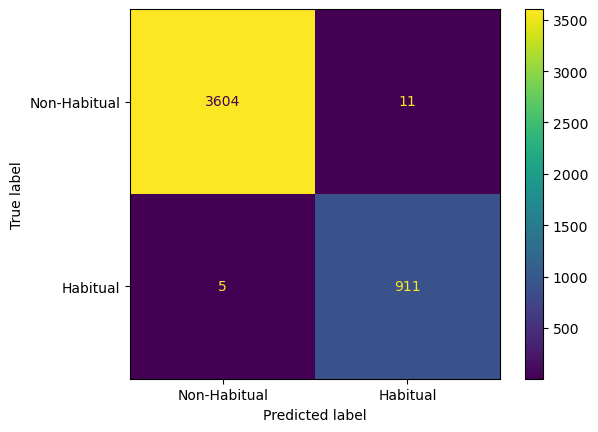

In [19]:
#Results
cm2 = confusion_matrix(y, predictions)
cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['Non-Habitual','Habitual'])
cmd2.plot()
print(classification_report(y, predictions, target_names=target_names))

In [20]:
#Increasing the recall by increasing the confidence required for the model to classify a sentence as non-habitual
kfold = StratifiedKFold(n_splits=10)
prediction_probs = cross_val_predict(model4, X, y, cv=kfold, method = 'predict_proba')
prediction_new = copy.deepcopy(prediction_probs)
prediction_new = prediction_new[:,0]
for i in range(len(prediction_probs)):
    if (prediction_new[i] >= 0.84):
        prediction_new[i] = -1
    else:
        prediction_new[i] = 1

data_new = copy.deepcopy(data)
data_new.insert(1, 'Probability Non-Habitual', prediction_probs[:,0])

#Fitting model to the explanatory and response variables
model_fit = model4.fit(X,y)

# Setting the predictions of data_new to prediction_new instead of prediction_probs
for i in range(len(data_new)):
   data_new.iat[i,0] = prediction_new[i]

              precision    recall  f1-score   support

 nonhabitual       1.00      0.99      0.99      3615
    habitual       0.96      1.00      0.98       916

    accuracy                           0.99      4531
   macro avg       0.98      0.99      0.99      4531
weighted avg       0.99      0.99      0.99      4531



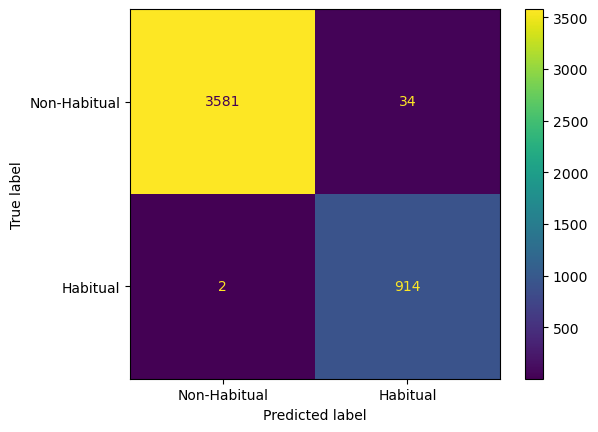

In [21]:
# Print results with higher threshold
cm3 = confusion_matrix(y, prediction_new)
cmd3 = ConfusionMatrixDisplay(cm3, display_labels=['Non-Habitual','Habitual'])
cmd3.plot()
print(classification_report(y, prediction_new, target_names=target_names))

In [22]:
#Exporting the habitual model
joblib.dump(model_fit, "habituality_model.joblib")

['habituality_model.joblib']